In [26]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from EngineerFeature import FeatureEngineer
from sklearn.discriminant_analysis import StandardScaler
scaler = StandardScaler()

In [27]:
# Normalized, one-hot-encoded, and feature-engineered dataset
data = pd.read_csv('../final_data.csv')

In [28]:
# Splitting features and target variable
X = data.drop("popularity", axis=1)   # features
y = data["popularity"]               # target

In [29]:
# Split the dataset into training(%70), validation(%15), and test(%15) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
fe = FeatureEngineer()
X_train = fe.fit_transform(X_train, y_train)
X_test = fe.transform(X_test)
cols = X_train.columns#.difference(['artist_avg_popularity'])#, 'artist_song_count'])
X_train = pd.DataFrame(
    scaler.fit_transform(X_train[cols]),
    columns=cols,#X_train.columns,
    index=X_train.index
)
X_test = pd.DataFrame(
    scaler.transform(X_test[cols]),
    columns=cols,#X_test.columns,
    index=X_test.index
)
print(X_train.shape, X_test.shape)

(22684, 40) (5672, 40)


In [30]:
param_dist = {
    "n_estimators": [300, 500, 700],
    "max_depth": [4, 6, 8],          # RF had 30 → but XGB must be much shallower
    "learning_rate": [0.03, 0.05, 0.1],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.3, 0.5],  # RF had 0.3 → keep near it
    "min_child_weight": [5, 10, 20], # RF leaf constraints → XGB equivalent
    "gamma": [0, 0.1, 0.3],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 2]
}

X_sub = X_train.sample(frac=0.5, random_state=42)
y_sub = y_train.loc[X_sub.index]

In [31]:
xgb_base = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=42
)

randomizedCV = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

randomizedCV.fit(X_sub, y_sub)
print("Best XGB params:", randomizedCV.best_params_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best XGB params: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.5}


In [32]:
best_params = randomizedCV.best_params_

final_xgb = xgb.XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="mae",
    early_stopping_rounds=20,  # Enable early stopping
    random_state=42
)

In [33]:
final_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5
,device,None
,early_stopping_rounds,20
,enable_categorical,False
,eval_metric,'mae'


In [34]:
preds = final_xgb.predict(X_test)

print("MAE :", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R²  :", r2_score(y_test, preds))

MAE : 15.183109283447266
RMSE: 20.053254751362605
R²  : 0.2869263291358948


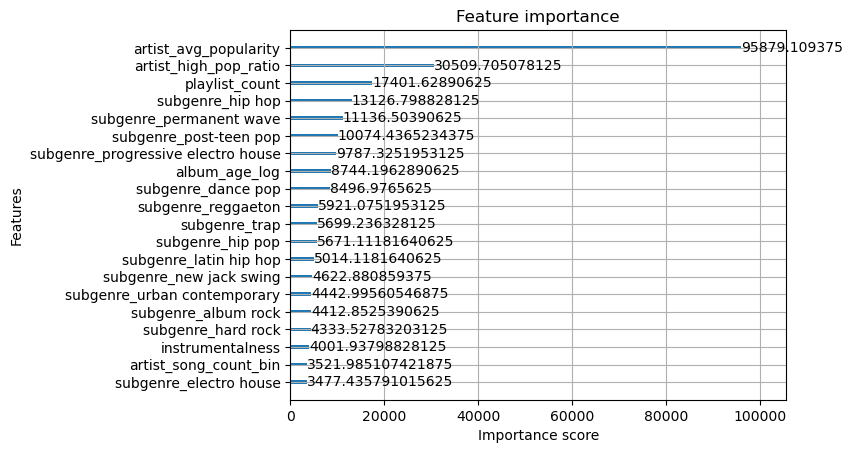

In [35]:
xgb.plot_importance(final_xgb, importance_type="gain", max_num_features=20)
plt.show()


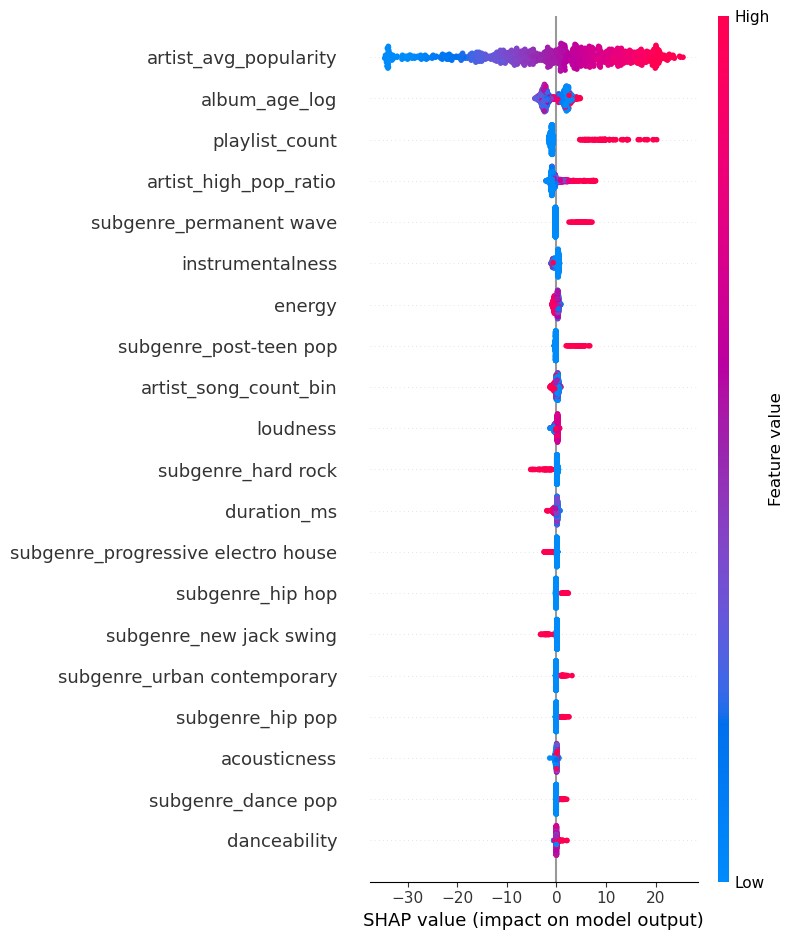

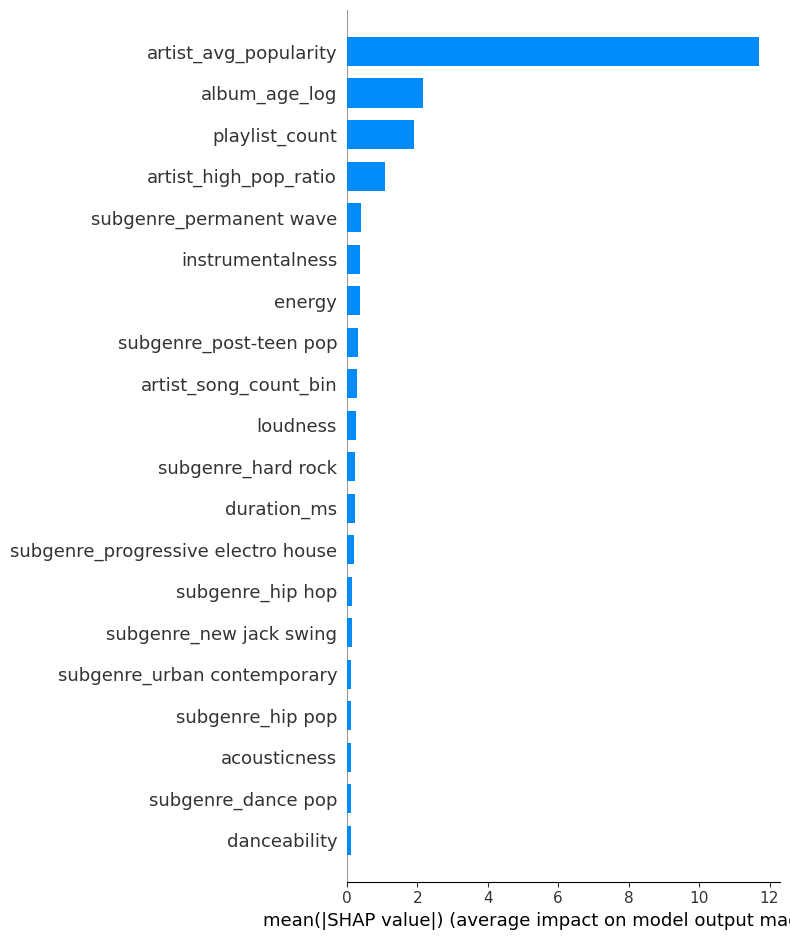

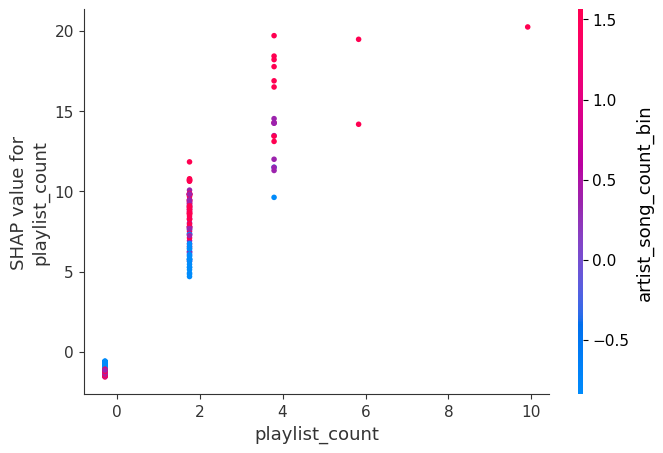

In [36]:
explainer = shap.TreeExplainer(final_xgb)
X_sample = X_train.sample(1000, random_state=42)
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)

shap.summary_plot(shap_values, X_sample, plot_type="bar")

shap.dependence_plot("playlist_count", shap_values, X_sample)


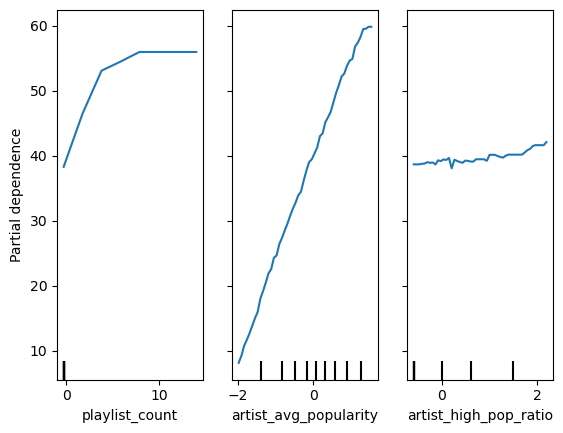

In [37]:
features = ["playlist_count", "artist_avg_popularity", "artist_high_pop_ratio"]

PartialDependenceDisplay.from_estimator(
    final_xgb,
    X_train,
    features,
    grid_resolution=50
)
plt.show()

XGBOOST WITH OPTUNA

In [39]:
from xgboost import XGBRegressor
!pip install optuna
import optuna
from sklearn.model_selection import cross_val_score


   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.1 MB 672.2 kB/s eta 0:00:03
   -------------- ------------------------- 0.8/2.1 MB 745.8 kB/s eta 0:00:02
   ------------------- -------------------- 1.0/2.1 MB 868.0 kB/s eta 0:00:02
   ------------------- -------------------- 1.0/2.1 MB 868.0 kB/s eta 0:00:02
   ------------------------ --------------- 1.3/2.1 MB 849.7 kB/s eta 0:00:01
   ----------------------------- ---------- 1.6/2.1 MB 873.8 kB/s eta 0:00:01
   ---------------------------------- ----- 1.8/2.1 MB 907.1 kB/s eta 0:00:01
   ---------------------------------- ----- 1.8/2.1 MB 907.1 kB/s eta 0:00:01
   ----------------------------

In [40]:
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    n_estimators=400,
    learning_rate=0.08,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_base.fit(X_train, y_train)
y_pred = xgb_base.predict(X_test)

In [41]:
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²  :", r2_score(y_test, y_pred))

MAE : 15.33354663848877
RMSE: 20.448951242877804
R²  : 0.25850754976272583


In [42]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.0, 3.0),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    score = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score

In [43]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

[I 2025-12-12 17:31:51,172] A new study created in memory with name: no-name-8dc7fa84-23ee-445e-a848-821a7102d4ea


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-12-12 17:32:01,052] Trial 0 finished with value: 10.362432098388672 and parameters: {'n_estimators': 479, 'learning_rate': 0.04770275195216359, 'max_depth': 10, 'min_child_weight': 9, 'gamma': 1.3845375302285203, 'subsample': 0.7197293968955049, 'colsample_bytree': 0.7129665594563146, 'reg_alpha': 0.05293611178133961, 'reg_lambda': 0.87303083799799}. Best is trial 0 with value: 10.362432098388672.
[I 2025-12-12 17:32:05,282] Trial 1 finished with value: 10.055214118957519 and parameters: {'n_estimators': 343, 'learning_rate': 0.04453688905863544, 'max_depth': 9, 'min_child_weight': 13, 'gamma': 1.8724954136851233, 'subsample': 0.8924302279802669, 'colsample_bytree': 0.7225251548011875, 'reg_alpha': 0.7808305915905047, 'reg_lambda': 0.27429915663841087}. Best is trial 1 with value: 10.055214118957519.
[I 2025-12-12 17:32:12,052] Trial 2 finished with value: 10.792982292175292 and parameters: {'n_estimators': 364, 'learning_rate': 0.10335682123861749, 'max_depth': 10, 'min_child_

In [44]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=80, show_progress_bar=True)

[I 2025-12-12 17:35:11,522] A new study created in memory with name: no-name-f8f6fc9c-f6f8-4085-85ff-6662102df6a5


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2025-12-12 17:35:13,892] Trial 0 finished with value: 10.02315559387207 and parameters: {'n_estimators': 844, 'learning_rate': 0.10070213203066217, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 1.9321047262834876, 'subsample': 0.8915122279402752, 'colsample_bytree': 0.7635910563399293, 'reg_alpha': 0.5115174513271431, 'reg_lambda': 0.5976635695378908}. Best is trial 0 with value: 10.02315559387207.
[I 2025-12-12 17:35:21,369] Trial 1 finished with value: 10.199728775024415 and parameters: {'n_estimators': 652, 'learning_rate': 0.032872277286063185, 'max_depth': 9, 'min_child_weight': 14, 'gamma': 2.561267207595787, 'subsample': 0.6046813516253967, 'colsample_bytree': 0.6967591617118298, 'reg_alpha': 0.401158363231259, 'reg_lambda': 0.24259971144467596}. Best is trial 0 with value: 10.02315559387207.
[I 2025-12-12 17:35:22,638] Trial 2 finished with value: 9.941691780090332 and parameters: {'n_estimators': 479, 'learning_rate': 0.10929750872503324, 'max_depth': 3, 'min_child_weight

In [45]:
best_params = study.best_params
best_params

{'n_estimators': 302,
 'learning_rate': 0.022239387746992956,
 'max_depth': 7,
 'min_child_weight': 11,
 'gamma': 2.839089230970166,
 'subsample': 0.7676378697136007,
 'colsample_bytree': 0.8808158125355683,
 'reg_alpha': 0.2916884670340741,
 'reg_lambda': 0.7835099092974832}

In [46]:
# Final test set evaluation with the best hyperparameters

best_xgb = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 15.161032676696777
RMSE: 20.191611423435226
R2: 0.27705276012420654


GridSearch + Optuna

In [47]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import optuna


In [48]:
param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.06, 0.1],
    "min_child_weight": [5, 10],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "n_estimators": [300, 500]
}

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("GridSearch best params:", grid.best_params_)
print("GridSearch best MAE:", -grid.best_score_)

GridSearch best params: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 300, 'subsample': 0.8}
GridSearch best MAE: 9.752824147542318


In [49]:
best_grid = grid.best_params_

def objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", best_grid["max_depth"]-2, best_grid["max_depth"]+2),
        "learning_rate": trial.suggest_float("learning_rate", best_grid["learning_rate"]/2, best_grid["learning_rate"]*1.5),
        "min_child_weight": trial.suggest_int("min_child_weight", best_grid["min_child_weight"]//2, best_grid["min_child_weight"]*2),
        "subsample": trial.suggest_float("subsample", best_grid["subsample"]-0.2, best_grid["subsample"]+0.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", best_grid["colsample_bytree"]-0.2, best_grid["colsample_bytree"]+0.2),
        "n_estimators": trial.suggest_int("n_estimators", best_grid["n_estimators"]-200, best_grid["n_estimators"]+300),
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    score = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score

In [51]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)   # 40 trial yeterli!

[I 2025-12-12 17:56:33,297] A new study created in memory with name: no-name-ec380a2b-bca7-47a4-9836-63a3b999ad41


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-12-12 17:56:37,626] Trial 0 finished with value: 9.8256010055542 and parameters: {'max_depth': 5, 'learning_rate': 0.026160855952351694, 'min_child_weight': 17, 'subsample': 0.8788215305677032, 'colsample_bytree': 0.6138736813885113, 'n_estimators': 287}. Best is trial 0 with value: 9.8256010055542.
[I 2025-12-12 17:56:40,995] Trial 1 finished with value: 10.125383949279785 and parameters: {'max_depth': 4, 'learning_rate': 0.02484386568306119, 'min_child_weight': 5, 'subsample': 0.7226062516787103, 'colsample_bytree': 0.9698551247720515, 'n_estimators': 120}. Best is trial 0 with value: 9.8256010055542.
[I 2025-12-12 17:56:43,919] Trial 2 finished with value: 9.92091770172119 and parameters: {'max_depth': 4, 'learning_rate': 0.025204793894075102, 'min_child_weight': 8, 'subsample': 0.6610248602945387, 'colsample_bytree': 0.9215428256128371, 'n_estimators': 152}. Best is trial 0 with value: 9.8256010055542.
[I 2025-12-12 17:56:50,457] Trial 3 finished with value: 9.9454698562622

In [52]:
best_params = study.best_params
best_params

{'max_depth': 6,
 'learning_rate': 0.0347436947969942,
 'min_child_weight': 16,
 'subsample': 0.8074763699527615,
 'colsample_bytree': 0.9968046731351767,
 'n_estimators': 248}

In [53]:
# Final test set evaluation with the best hyperparameters

best_xgb = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

MAE: 15.170287132263184
RMSE: 20.19698599811871
R2: 0.27666783332824707


2. deneme

In [54]:
param_grid2 = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.03, 0.06, 0.1],
    "min_child_weight": [3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "n_estimators": [300, 500, 700],
}

In [55]:
xgb_base2 = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

grid2 = GridSearchCV(
    estimator=xgb_base2,
    param_grid=param_grid2,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid2.fit(X_train, y_train)

print("GridSearch best params:", grid2.best_params_)
print("GridSearch best MAE:", -grid2.best_score_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
GridSearch best params: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 300, 'subsample': 0.6}
GridSearch best MAE: 9.688779513041178


In [56]:
best_grid = grid2.best_params_

def objective2(trial):

    params = {
        "max_depth": trial.suggest_int(
            "max_depth",
            max(3, best_grid["max_depth"] - 2),
            best_grid["max_depth"] + 2
        ),

        "learning_rate": trial.suggest_float(
            "learning_rate",
            best_grid["learning_rate"] * 0.5,
            best_grid["learning_rate"] * 1.5
        ),

        "min_child_weight": trial.suggest_int(
            "min_child_weight",
            max(1, best_grid["min_child_weight"] // 2),
            best_grid["min_child_weight"] * 2
        ),

        "subsample": trial.suggest_float(
            "subsample",
            max(0.5, best_grid["subsample"] - 0.2),
            min(1.0, best_grid["subsample"] + 0.2)
        ),

        "colsample_bytree": trial.suggest_float(
            "colsample_bytree",
            max(0.5, best_grid["colsample_bytree"] - 0.2),
            min(1.0, best_grid["colsample_bytree"] + 0.2)
        ),

        "n_estimators": trial.suggest_int(
            "n_estimators",
            max(200, best_grid["n_estimators"] - 200),
            best_grid["n_estimators"] + 300
        ),

        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBRegressor(**params)

    score = cross_val_score(
        model, X_train, y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1
    ).mean()

    return -score

In [57]:
study = optuna.create_study(
    direction="minimize"
)

study.optimize(objective2, n_trials=50, show_progress_bar=True)

[I 2025-12-12 18:16:04,015] A new study created in memory with name: no-name-b72a32ef-49f4-4f23-b2b5-555d2fae61cd


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-12 18:16:07,690] Trial 0 finished with value: 9.715721893310548 and parameters: {'max_depth': 7, 'learning_rate': 0.025255130744873306, 'min_child_weight': 11, 'subsample': 0.7243865889657625, 'colsample_bytree': 0.9858580560715585, 'n_estimators': 486}. Best is trial 0 with value: 9.715721893310548.
[I 2025-12-12 18:16:09,971] Trial 1 finished with value: 9.749169540405273 and parameters: {'max_depth': 8, 'learning_rate': 0.03550005645714127, 'min_child_weight': 9, 'subsample': 0.5115473388238033, 'colsample_bytree': 0.9130348621930455, 'n_estimators': 212}. Best is trial 0 with value: 9.715721893310548.
[I 2025-12-12 18:16:14,373] Trial 2 finished with value: 9.79829807281494 and parameters: {'max_depth': 8, 'learning_rate': 0.026519088368988177, 'min_child_weight': 6, 'subsample': 0.7669868113236326, 'colsample_bytree': 0.8057121782866724, 'n_estimators': 351}. Best is trial 0 with value: 9.715721893310548.
[I 2025-12-12 18:16:18,763] Trial 3 finished with value: 9.724620

In [58]:
best_optuna = study.best_params
best_optuna


{'max_depth': 6,
 'learning_rate': 0.018546978112858534,
 'min_child_weight': 19,
 'subsample': 0.6824724944233201,
 'colsample_bytree': 0.9383722748644169,
 'n_estimators': 456}

In [59]:
best_xgb = XGBRegressor(
    **best_optuna,
    objective="reg:squarederror",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)

In [60]:
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test R2:", r2_score(y_test, y_pred))


Test MAE: 15.164834022521973
Test RMSE: 20.182337617555216
Test R2: 0.2777166962623596


In [61]:
import shap

explainer = shap.TreeExplainer(best_xgb)  # final model
shap_values = explainer.shap_values(X_test)

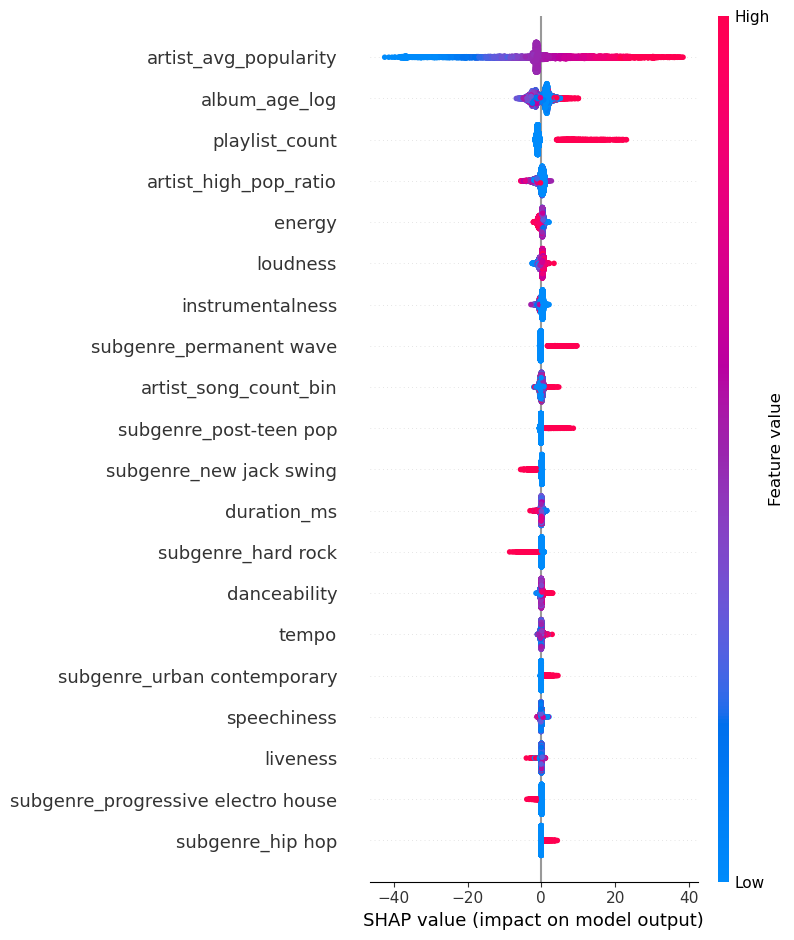

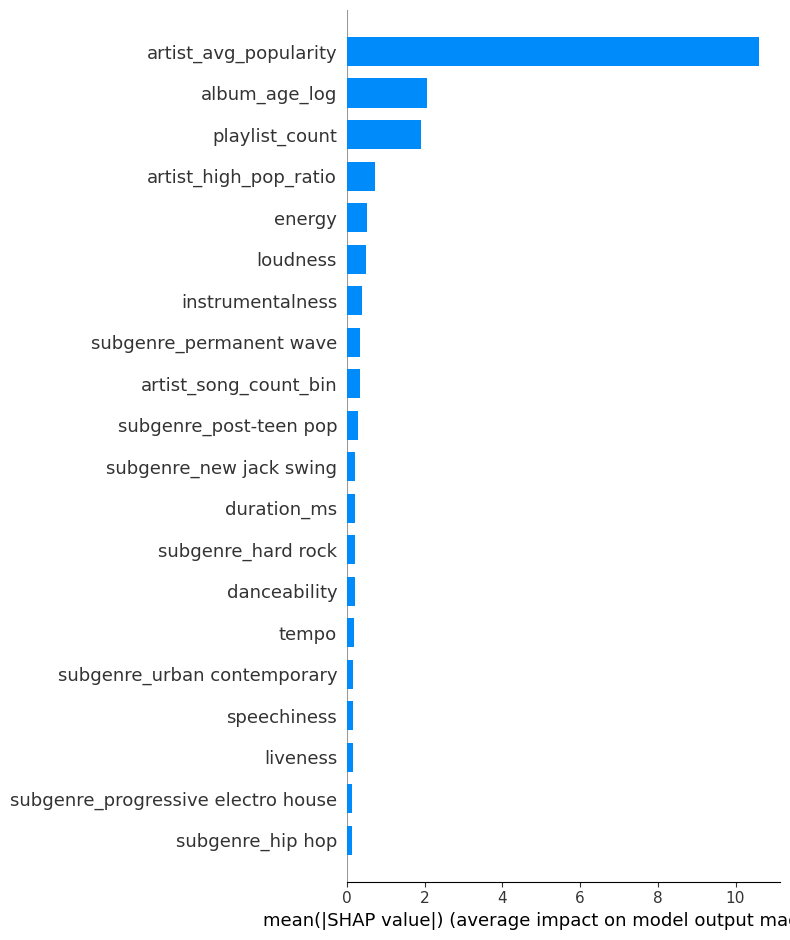

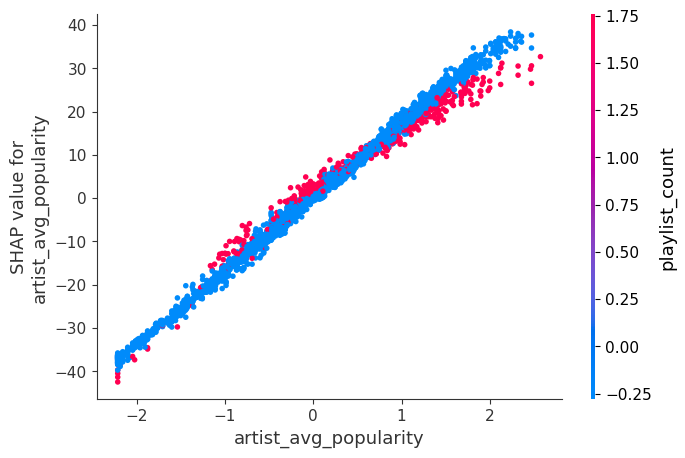

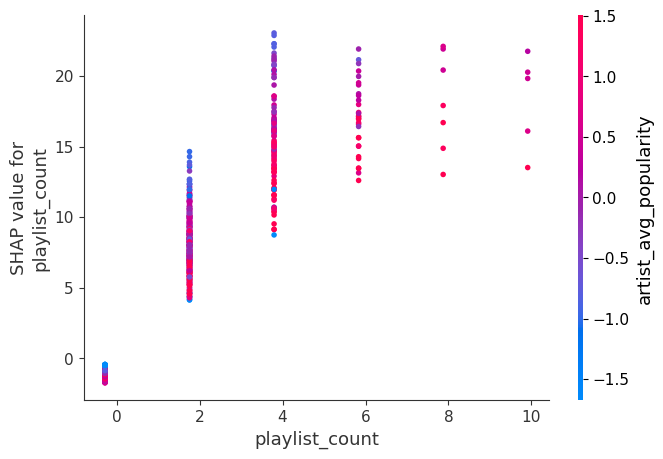

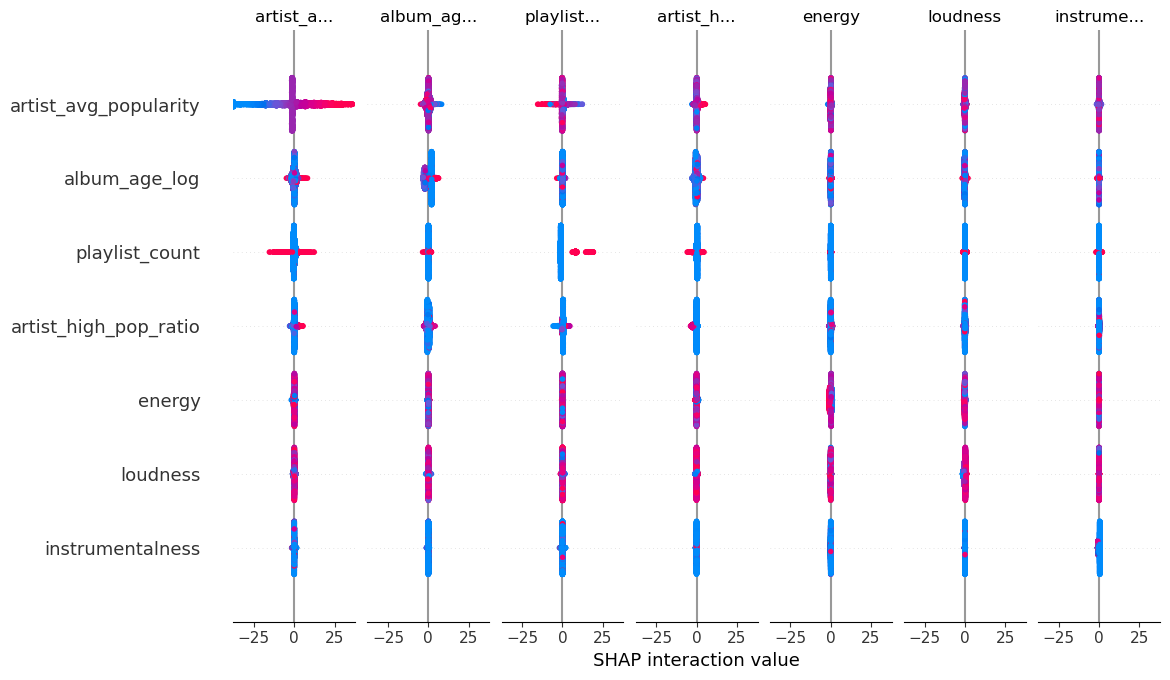

In [62]:
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.dependence_plot("artist_avg_popularity", shap_values, X_test)
shap.dependence_plot("playlist_count", shap_values, X_test)

interaction_values = explainer.shap_interaction_values(X_test)
shap.summary_plot(interaction_values, X_test)

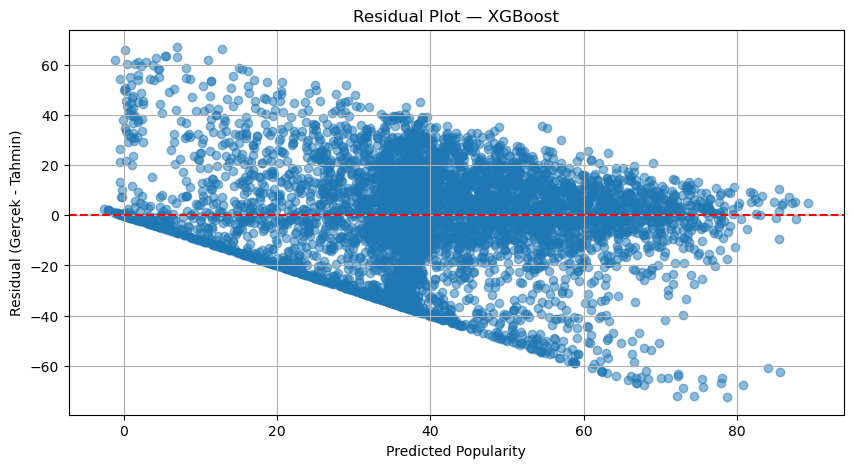

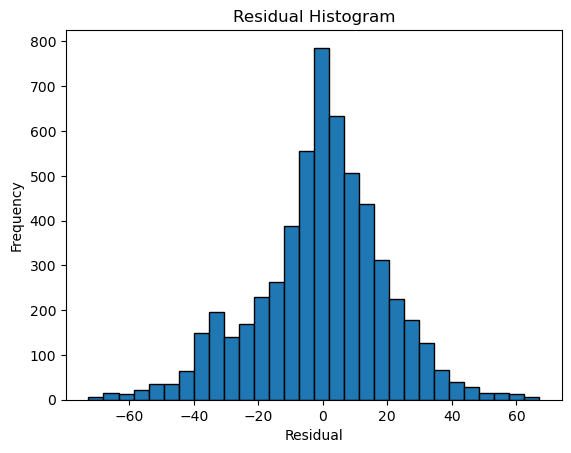

In [63]:
y_pred = best_xgb.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Popularity")
plt.ylabel("Residual (Gerçek - Tahmin)")
plt.title("Residual Plot — XGBoost")
plt.grid(True)
plt.show()

plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Residual Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


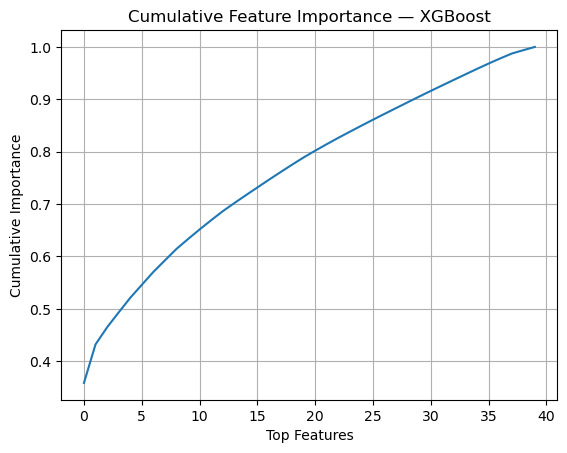

In [64]:
imp = best_xgb.feature_importances_
sorted_imp = np.sort(imp)[::-1]
cumulative = np.cumsum(sorted_imp)

plt.plot(cumulative)
plt.xlabel("Top Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance — XGBoost")
plt.grid(True)
plt.show()

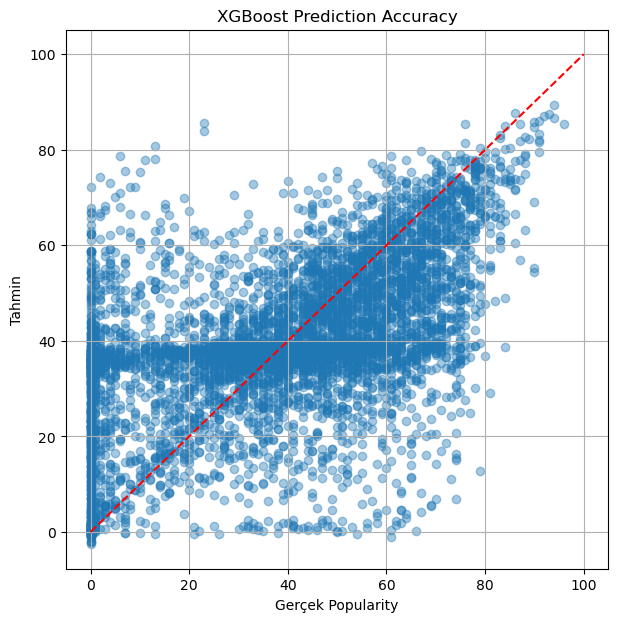

In [65]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0,100], [0,100], 'r--')
plt.xlabel("Gerçek Popularity")
plt.ylabel("Tahmin")
plt.title("XGBoost Prediction Accuracy")
plt.grid(True)
plt.show()
